# Code for a optimization diet

In [1]:
#Import libraries
import gurobipy as gb
from gurobipy import GRB, Model, quicksum
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('reduced_dataset_cost_adjusted.csv')
data = data.reset_index()

# Assuming your dataset is in a Pandas DataFrame called 'data'
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,level_0,index,food_name,WWEIA Category description,WWEIA Category number,Energy (kcal),Is_vegeterian,Protein (g),Carbohydrate (g),"Sugars, total\n(g)",...,Alcohol (g),Water\n(g),is_breakfast,is_lunch_dinner,Cost_CAD,carbon_footprint_gCO2,water_footprint_liters,is_lunch,Unnamed: 57,Protein (g).1
0,109,154,Chicken or turkey parmigiana,Poultry mixed dishes,3004,174.0,0,16.25,8.30,1.68,...,0,65.04,0,1,6.0,1243.0,706.0,NaN,NaN,16.25
1,389,547,Shrimp and vegetables excluding carrots,Seafood mixed dishes,3006,124.0,0,9.25,6.78,1.20,...,0,75.98,0,1,6.0,335.0,196.0,NaN,NaN,9.25
2,55,86,Bruschetta,Vegetable sandwiches/burgers,3744,171.0,0,4.29,21.32,3.34,...,0,65.58,0,1,3.0,538.0,352.0,NaN,NaN,4.29
3,355,501,Rice with squid,Rice mixed dishes,3202,264.0,0,8.87,29.31,1.10,...,0,47.70,0,1,4.0,685.0,406.0,NaN,NaN,8.87
4,278,383,Macaroni or pasta salad with tuna and egg,"Pasta mixed dishes, excludes macaroni and cheese",3204,197.0,0,7.14,19.36,1.53,...,0,62.70,0,1,4.0,517.5,305.5,NaN,NaN,7.14


In [6]:
data.groupby(by = 'WWEIA Category description')['Cost_CAD'].mean()

WWEIA Category description
Bagels and English muffins                          2.000000
Bean, pea, legume dishes                            4.516190
Burgers                                             6.000000
Burritos and tacos                                  4.000000
Cheese sandwiches                                   2.000000
Chicken fillet sandwiches                           4.000000
Deli and cured meat sandwiches                      4.250000
Egg rolls, dumplings, sushi                         4.625000
Egg/breakfast sandwiches                            4.000000
Eggs and omelets                                    2.000000
Frankfurter sandwiches                              4.000000
Macaroni and cheese                                 3.500000
Meat and BBQ sandwiches                             4.000000
Meat mixed dishes                                   5.548387
Oatmeal                                             1.000000
Pancakes, waffles, French toast                     2.0000

In [4]:
data['WWEIA Category description'].value_counts()

WWEIA Category description
Seafood mixed dishes                                76
Poultry mixed dishes                                68
Meat mixed dishes                                   62
Deli and cured meat sandwiches                      38
Pasta mixed dishes, excludes macaroni and cheese    36
Rice mixed dishes                                   29
Bean, pea, legume dishes                            21
Vegetable dishes                                    20
Egg/breakfast sandwiches                            20
Burgers                                             17
Pizza                                               15
Meat and BBQ sandwiches                             15
Seafood sandwiches                                  10
Eggs and omelets                                    10
Soy and meat-alternative products                    9
Egg rolls, dumplings, sushi                          8
Vegetable sandwiches/burgers                         8
Macaroni and cheese                   

In [2]:
#Function to run model based on user input:
def meal_opt(objective, weight_kg, gender, vegetarian, importance, budget):

    #Define model
    model = Model("Meal Optimization")
    model.Params.OutputFlag = 0

    #Dishes
    I = data['food_name']
    #Meals per day
    J = ['Breakfast', 'Lunch', 'Dinner']
    #Days in the week
    K = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #Cost of the dishes
    Cost = data['Cost_CAD']

    #Macronutrients for each of the dishes
    Proteins = data['Protein (g)']
    Sugars = data['Sugars, total\n(g)']
    CO2 = data['carbon_footprint_gCO2']
    water = data['water_footprint_liters']
    

    #Max sugar intake for each gender
    max_sugar = 25 if gender == "women" else 36

    #Binary indicators for meals wether it is breakfast or vegetarian
    is_breakfast = data['is_breakfast'] #Binary 1 if the dish is breakfast
    is_vegetarian = data['Is_vegeterian'] #Binary 1 if the dish is vegetarian

    #Number of dishes
    num_dishes = len(I)
    #Number of meals per day
    num_meals = len(J)
    #Number os days per week
    num_days = len(K)

    #Sustainability Score: higher score means more environmental impact
    scaler = MinMaxScaler()
    CO2_normalized = scaler.fit_transform(data['carbon_footprint_gCO2'].values.reshape(-1,1))
    Water_usage_normalized = scaler.fit_transform(data['water_footprint_liters'].values.reshape(-1,1))
    sustainability_score = 0.5*CO2_normalized + 0.5*Water_usage_normalized

    #Large constant
    M = 100000000

    #Minimum requirements for macronutrients based on the objectives
    min_protein = {'weight loss': 1 * weight_kg, 'muscle gain': 1.7 * weight_kg}

    #Maximum number of servings
    max_servings = {('weight loss', 1): 3, ('muscle gain', 1): 4, ('weight loss', 0): 2, ('muscle gain', 0): 3}

    #Priorities based on user input
    if importance == "proteins":
        priority_proteins = 1 # Higher priority for proteins
        priority_sustainability = 0  #Lower priority for sustainability
    elif importance == "sustainability":
        priority_proteins = 0  # Lower priority for proteins
        priority_sustainability = 1  #Higher priority for sustainability
    elif importance == "equal":
        priority_proteins = 1
        priority_sustainability = 1

    #Decision Variables
    X = model.addVars(num_dishes, num_meals, num_days, lb = 0, vtype = GRB.CONTINUOUS, 
                    name = ['Number of portions from ' + I[i] + 'for ' + J[j] + ' on day ' + K[k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days)])
    Y = model.addVars(num_dishes, num_meals, num_days, vtype = GRB.BINARY, name = 'Aux. Variable')

    #Constraints
    #Constraint_1: Select only one dish per meal
    model.addConstrs(X[i,j,k] <= M* Y[i,j,k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    model.addConstrs(quicksum(Y[i,j,k] for i in range(num_dishes)) == 1 for j in range(num_meals) for k in range(num_days))

    #Constraint_2: For each day, the plan should suggest 3 meals (1 breakfast, 1 lunch, 1 dinner):
    model.addConstrs(Y[i,j,k] <= X[i,j,k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constrain_3: All dishes must be different for the weekly meal plan 
    model.addConstrs(quicksum(Y[i,j,k] for j in range(num_meals) for k in range(num_days)) <= 1 for i in range(num_dishes))

    #Constraint_4: On breakfast you can only choose breakfast options
    model.addConstrs(X[i,0,k] <= is_breakfast[i]*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_5: On lunch and dinner you can choose options different to the ones of breakfast
    model.addConstrs(X[i,1,k] <= (1-is_breakfast[i])*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    model.addConstrs(X[i,2,k] <= (1-is_breakfast[i])*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_6: Vegetarians must only receive vegetarian recommendations
    if vegetarian == 1:
        model.addConstrs(X[i,j,k] <= is_vegetarian[i]*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_7: Maximum 4 serving per meal (max 400 grs / mean) - balanced distribution
    model.addConstrs(quicksum(X[i,j,k] for i in range(num_dishes)) <= max_servings[objective, vegetarian] for j in range(num_meals) for k in range(num_days))
    

    #Constraint_8: Minimum protein requirements
    model.addConstrs(quicksum(X[i,j,k]*Proteins[i] for i in range(num_dishes) for j in range(num_meals)) >= min_protein[objective] for k in range(num_days))

    #Constraint_9: Max Intake of Sugar / day:
    model.addConstrs(quicksum(X[i,j,k]*Sugars[i] for i in range(num_dishes) for j in range(num_meals)) <= max_sugar for k in range(num_days))

    #Constraint_10: Budget Constraint
    model.addConstr(quicksum(X[i,j,k]*Cost[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days)) <= budget)

    
    #Multiple objective functions
    exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    exp_2 = sum(X[i,j,k]*Proteins[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    
    #Setting multiple objectives
    
    model.setObjectiveN(exp_1, index = 0, priority = priority_sustainability) #Minimizes sustainability/user chooses priority
    model.setObjectiveN(-exp_2, index = 1, priority = priority_proteins) #Maximizes protein/user chooses priority 

    #Minimization of the objectives respecting their priorities
    #Minimize cost and sustainability score (higher score=more imapct)
    #Maximize protein intake
    model.ModelSense = GRB.MINIMIZE

    #Optimize the model
    model.optimize()

    #Display results
    if model.status == GRB.OPTIMAL:
        #Title
        print("\n\033[4mOptimal Meal Plan:\033[0m")

        #Store cost for the week
        Total_Cost = model.ObjVal
        weekly_cost = 0
        weekly_sustainability = 0
        weekly_protein = 0
        weekly_co2 = 0
        weekly_water = 0
        
        #loop through each day
        for k in range(num_days):
            print(f"\n\033[4m{K[k]}:\033[0m")
            total_protein = 0
            daily_cost = 0
            daily_sustainability = 0   
            daily_co2 = 0
            daily_water = 0 

            #loop through each meal
            for j in range(num_meals):
                meal_protein = 0
                meal_cost = 0
                meal_sustainability = 0
                meal_co2 = 0
                meal_water = 0

                #loop through each dish
                for i in range(num_dishes):
                    quantity = X[i,j,k].x
                    if quantity >= 1:
                        dish_cost = quantity * Cost[i]
                        meal_cost += dish_cost
                        

                        #macronutrients count
                        meal_protein += Proteins[i] * quantity

                        #meal name with portion quantity and cost
                        print(f'{J[j]}: {quantity:.1f} portions of 100g of dish {I[i]} --> Cost: ${dish_cost:.2f}')

                        #sustainability score
                        meal_sustainability += sustainability_score[i].item() * quantity

                        #CO2 Score
                        meal_co2 += CO2[i] * quantity

                        #Water Usage
                        meal_water += water[i] * quantity



                #total sustainability score for meal
                print(f"\033[3m--> Meal Sustainability Score: {meal_sustainability:.2f}\033[0m")

                #total CO2 score for meal
                print(f"\033[3m--> Meal CO2: {meal_co2:.2f}g\033[0m")

                #total water usage for meal
                print(f"\033[3m--> Water Usage: {meal_water:.2f}l\033[0m")

                #total macronutrient intake for meal
                print(f"\033[3m--> Proteins: {meal_protein:.2f}g\033[0m")
                
                #total macronutrient and sustainability intake daily
                daily_sustainability += meal_sustainability
                total_protein += meal_protein
                daily_cost += meal_cost
                daily_co2 += meal_co2
                daily_water += meal_water
                
            #print daily macronutrients and sustainability intake and daily cost   
            print(f"Total Macronutrients Intake: \n\033[3m--> Total Protein: {total_protein:.2f}g\033[0m")
            print(f'Total Daily Cost: \n\033[3m--> ${daily_cost:.2f}\033[0m')
            print(f'Total Daily Sustainability Score: \n\033[3m--> {daily_sustainability:.2f}\033[0m')
            print(f'Total Daily CO2: \n\033[3m--> {daily_co2:.2f}\033[0m')
            print(f'Total Daily Water: \n\033[3m--> {daily_water:.2f}\033[0m')

            #accumulate daily cost into weekly cost
            weekly_cost += daily_cost
            weekly_sustainability += daily_sustainability
            weekly_protein += total_protein
            weekly_co2 += daily_co2
            weekly_water += daily_water

        #Print weekly cost
        print(f"\n\033[4mTotal Cost for the Week:\033[0m ${weekly_cost:.2f}")

        #Print weekly sustainability score
        print(f"--> Total Sustainability Score for the Week: {weekly_sustainability:.2f}")

        #Print CO2:
        print(f"--> Total CO2: {weekly_co2:.2f}g")

        #Print Water:
        print(f"--> Total Water Usage: {weekly_water:.2f}l")

        #Print weekly protein intake
        print(f"--> Total Protein Intake for the Week: {weekly_protein:.2f}g\n")


        return True

    else:
        print("No optimal solution found.")
        return False

# User prompt for a tailor diet

In [6]:
#User prompt to run model
while True:
    #prompt for user objective
    objective = input("Enter your objective (weight loss or muscle gain): ").strip().lower()
    
    if objective in ["weight loss", "muscle gain"]:
        #prompt for user weight
        while True:
            try:
                weight_kg = float(input("Enter your weight in kg: "))
                if weight_kg > 0:
                    break
                else:
                    print("Weight must be a positive number. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a valid number for weight.")

        #prompt for user gender
        while True:
            gender = input("Enter your gender (Men/Women): ").strip().lower()
            if gender in ["men", "women"]:
                break
            else:
                print("Invalid gender. Please choose 'Men' or 'Women'.")

        #prompt for asking user if they are vegetarian
        while True:
            try:
                vegetarian = int(input("Are you vegetarian? Enter '1' for Yes or '0' for No").strip())
                if vegetarian in [0, 1]:
                    break
                else:
                    print("Invalid input. Please enter '1' for Yes or '0' for No")
            except ValueError:
                print("Invalid input. Please enter '1' for Yes or '0' for No")    

        #prompt for user importance on proteins/sustainability
        while True:
            importance = input("Which is more important to you? Maximizing 'proteins' intake or contributing to 'sustainability'? \nYou can also type 'equal' for equal importance").strip().lower()
            if importance in ["proteins", "sustainability", "equal"]:
                break
            else:
                print("Invalid input for importance. Please enter 'Proteins','Sustainability', or 'Equal'.")
        
        #prompt for user budget and ensure feasibility
        while True:
            try:
                budget = float(input("Enter your weekly budget in CAD (Minimum 150 CAD):").strip())
                if budget < 150:
                    print("We suggest a budget of more than or equal to 150 CAD. Please try again.")
                    continue
                
                #run model function
                feasible = meal_opt(objective, weight_kg, gender, vegetarian, importance, budget)

                if feasible:
                    print("Enjoy your meal plan!")
                    break
                else:
                    print("Please enter a higher budget.")
            except ValueError:
                print("Invalid input. Please enter a valid number for the budget.") 
        break
    
    #objective input invalidity
    else:
        print("Invalid objective. Please choose from 'weight loss' or 'muscle gain'.")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-29


C:\Users\Behzad\AppData\Local\Temp\ipykernel_2060\3612643559.py:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))



Optimal Meal Plan:

Monday:
Breakfast: 2.0 portions of 100g of dish Breakfast link (meat alternative products) --> Cost: $13.84
--> Meal Sustainability Score: 0.15
--> Meal CO2: 1580.00g
--> Water Usage: 1040.00l
--> Proteins: 40.56g
Lunch: 2.0 portions of 100g of dish Textured vegetable protein --> Cost: $10.00
--> Meal Sustainability Score: 0.17
--> Meal CO2: 1880.00g
--> Water Usage: 1118.00l
--> Proteins: 102.20g
Dinner: 2.0 portions of 100g of dish Chicken or turkey with cheese sauce --> Cost: $12.00
--> Meal Sustainability Score: 0.23
--> Meal CO2: 2472.00g
--> Water Usage: 1404.00l
--> Proteins: 43.54g
Total Macronutrients Intake: 
--> Total Protein: 186.30g
Total Daily Cost: 
--> $35.84
Total Daily Sustainability Score: 
--> 0.55
Total Daily CO2: 
--> 5932.00
Total Daily Water: 
--> 3562.00

Tuesday:
Breakfast: 2.0 portions of 100g of dish Breakfast pizza with egg --> Cost: $8.00
--> Meal Sustainability Score: 0.17
--> Meal CO2: 1802.00g
--> Water Usage: 1188.00l
--> Proteins:

In [45]:
#SENSITIVITY ANALYSIS
result = []
#Function to run model based on user input:
def meal_opt(objective, weight_kg, gender, vegetarian, importance, budget):

    #Define model
    model = Model("Meal Optimization")
    model.Params.OutputFlag = 0

    #Dishes
    I = data['food_name']
    #Meals per day
    J = ['Breakfast', 'Lunch', 'Dinner']
    #Days in the week
    K = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    #Cost of the dishes
    Cost = data['Cost_CAD']

    #Macronutrients for each of the dishes
    Proteins = data['Protein (g)']
    Sugars = data['Sugars, total\n(g)']
    CO2 = data['carbon_footprint_gCO2']
    water = data['water_footprint_liters']
    

    #Max sugar intake for each gender
    max_sugar = 25 if gender == "women" else 36

    #Binary indicators for meals wether it is breakfast or vegetarian
    is_breakfast = data['is_breakfast'] #Binary 1 if the dish is breakfast
    is_vegetarian = data['Is_vegeterian'] #Binary 1 if the dish is vegetarian

    #Number of dishes
    num_dishes = len(I)
    #Number of meals per day
    num_meals = len(J)
    #Number os days per week
    num_days = len(K)

    #Sustainability Score: higher score means more environmental impact
    scaler = MinMaxScaler()
    CO2_normalized = scaler.fit_transform(data['carbon_footprint_gCO2'].values.reshape(-1,1))
    Water_usage_normalized = scaler.fit_transform(data['water_footprint_liters'].values.reshape(-1,1))
    sustainability_score = 0.5*CO2_normalized + 0.5*Water_usage_normalized

    #Large constant
    M = 100000000

    #Minimum requirements for macronutrients based on the objectives
    min_protein = {'weight loss': 1 * weight_kg, 'muscle gain': 1.7 * weight_kg}

    #Maximum number of servings
    max_servings = {('weight loss', 1): 3, ('muscle gain', 1): 4, ('weight loss', 0): 2, ('muscle gain', 0): 3}

    #Priorities based on user input
    if importance == "proteins":
        priority_proteins = 1 # Higher priority for proteins
        priority_sustainability = 0  #Lower priority for sustainability
    elif importance == "sustainability":
        priority_proteins = 0  # Lower priority for proteins
        priority_sustainability = 1  #Higher priority for sustainability
    elif importance == "equal":
        priority_proteins = 1
        priority_sustainability = 1

    #Decision Variables
    X = model.addVars(num_dishes, num_meals, num_days, lb = 0, vtype = GRB.CONTINUOUS, 
                    name = ['Number of portions from ' + I[i] + 'for ' + J[j] + ' on day ' + K[k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days)])
    Y = model.addVars(num_dishes, num_meals, num_days, vtype = GRB.BINARY, name = 'Aux. Variable')

    #Constraints
    #Constraint_1: Select only one dish per meal
    model.addConstrs(X[i,j,k] <= M* Y[i,j,k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    model.addConstrs(quicksum(Y[i,j,k] for i in range(num_dishes)) == 1 for j in range(num_meals) for k in range(num_days))

    #Constraint_2: For each day, the plan should suggest 3 meals (1 breakfast, 1 lunch, 1 dinner):
    model.addConstrs(Y[i,j,k] <= X[i,j,k] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constrain_3: All dishes must be different for the weekly meal plan 
    model.addConstrs(quicksum(Y[i,j,k] for j in range(num_meals) for k in range(num_days)) <= 1 for i in range(num_dishes))

    #Constraint_4: On breakfast you can only choose breakfast options
    model.addConstrs(X[i,0,k] <= is_breakfast[i]*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_5: On lunch and dinner you can choose options different to the ones of breakfast
    model.addConstrs(X[i,1,k] <= (1-is_breakfast[i])*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    model.addConstrs(X[i,2,k] <= (1-is_breakfast[i])*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_6: Vegetarians must only receive vegetarian recommendations
    if vegetarian == 1:
        model.addConstrs(X[i,j,k] <= is_vegetarian[i]*M for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))

    #Constraint_7: Maximum 4 serving per meal (max 400 grs / mean) - balanced distribution
    model.addConstrs(quicksum(X[i,j,k] for i in range(num_dishes)) <= max_servings[objective, vegetarian] for j in range(num_meals) for k in range(num_days))
    

    #Constraint_8: Minimum protein requirements
    model.addConstrs(quicksum(X[i,j,k]*Proteins[i] for i in range(num_dishes) for j in range(num_meals)) >= min_protein[objective] for k in range(num_days))

    #Constraint_9: Max Intake of Sugar / day:
    model.addConstrs(quicksum(X[i,j,k]*Sugars[i] for i in range(num_dishes) for j in range(num_meals)) <= max_sugar for k in range(num_days))

    #Constraint_10: Budget Constraint
    model.addConstr(quicksum(X[i,j,k]*Cost[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days)) <= budget)

    
    #Multiple objective functions
    exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    exp_2 = sum(X[i,j,k]*Proteins[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
    
    #Setting multiple objectives
    
    model.setObjectiveN(exp_1, index = 0, priority = priority_sustainability) #Minimizes sustainability/user chooses priority
    model.setObjectiveN(-exp_2, index = 1, priority = priority_proteins) #Maximizes protein/user chooses priority 

    #Minimization of the objectives respecting their priorities
    #Minimize cost and sustainability score (higher score=more imapct)
    #Maximize protein intake
    model.ModelSense = GRB.MINIMIZE

    #Optimize the model
    model.optimize()

    #Display results
    if model.status == GRB.OPTIMAL:
        #Title
        #print("\n\033[4mOptimal Meal Plan:\033[0m")

        #Store cost for the week
        Total_Cost = model.ObjVal
        weekly_cost = 0
        weekly_sustainability = 0
        weekly_protein = 0
        weekly_co2 = 0
        weekly_water = 0
        
        #loop through each day
        for k in range(num_days):
            #print(f"\n\033[4m{K[k]}:\033[0m")
            total_protein = 0
            daily_cost = 0
            daily_sustainability = 0   
            daily_co2 = 0
            daily_water = 0 

            #loop through each meal
            for j in range(num_meals):
                meal_protein = 0
                meal_cost = 0
                meal_sustainability = 0
                meal_co2 = 0
                meal_water = 0

                #loop through each dish
                for i in range(num_dishes):
                    quantity = X[i,j,k].x
                    if quantity >= 1:
                        dish_cost = quantity * Cost[i]
                        meal_cost += dish_cost
                        

                        #macronutrients count
                        meal_protein += Proteins[i] * quantity

                        #meal name with portion quantity and cost
                        #print(f'{J[j]}: {quantity:.1f} portions of 100g of dish {I[i]} --> Cost: ${dish_cost:.2f}')

                        #sustainability score
                        meal_sustainability += sustainability_score[i].item() * quantity

                        #CO2 Score
                        meal_co2 += CO2[i] * quantity

                        #Water Usage
                        meal_water += water[i] * quantity



                #total sustainability score for meal
                #print(f"\033[3m--> Meal Sustainability Score: {meal_sustainability:.2f}\033[0m")

                #total CO2 score for meal
                #print(f"\033[3m--> Meal CO2: {meal_co2:.2f}g\033[0m")

                #total water usage for meal
                #print(f"\033[3m--> Water Usage: {meal_water:.2f}l\033[0m")

                #total macronutrient intake for meal
                #print(f"\033[3m--> Proteins: {meal_protein:.2f}g\033[0m")
                
                #total macronutrient and sustainability intake daily
                daily_sustainability += meal_sustainability
                total_protein += meal_protein
                daily_cost += meal_cost
                daily_co2 += meal_co2
                daily_water += meal_water
                
            #print daily macronutrients and sustainability intake and daily cost   
            #print(f"Total Macronutrients Intake: \n\033[3m--> Total Protein: {total_protein:.2f}g\033[0m")
            #print(f'Total Daily Cost: \n\033[3m--> ${daily_cost:.2f}\033[0m')
            #print(f'Total Daily Sustainability Score: \n\033[3m--> {daily_sustainability:.2f}\033[0m')
            #print(f'Total Daily CO2: \n\033[3m--> {daily_co2:.2f}\033[0m')
            #print(f'Total Daily Water: \n\033[3m--> {daily_water:.2f}\033[0m')

            #accumulate daily cost into weekly cost
            weekly_cost += daily_cost
            weekly_sustainability += daily_sustainability
            weekly_protein += total_protein
            weekly_co2 += daily_co2
            weekly_water += daily_water

        #Print weekly cost
        #print(f"\n\033[4mTotal Cost for the Week:\033[0m ${weekly_cost:.2f}")

        #Print weekly sustainability score
        #print(f"--> Total Sustainability Score for the Week: {weekly_sustainability:.2f}")

        #Print CO2:
        #print(f"--> Total CO2: {weekly_co2:.2f}g")

        #Print Water:
        #print(f"--> Total Water Usage: {weekly_water:.2f}l")

        #Print weekly protein intake
        #print(f"--> Total Protein Intake for the Week: {weekly_protein:.2f}g\n")


        return (weekly_sustainability, weekly_protein)

    else:
        #print("No optimal solution found.")
        return False


#########THIS CODE IS THE ONE THAT RUNS THE SENSITIVITY ANALYSIS###################
#You will need to modify manually the profile
for i in list(range(100,260,10)):
    print(i)
    #result = []
    if meal_opt('weight loss', 80, 'Men', 1, 'sustainability', i) == False:
        result.append((0,0))
    else:
        result.append(meal_opt('weight loss', 80, 'Men', 1, 'sustainability', i))

100


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


110


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


120


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


130


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


140


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


150


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


160


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


170


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


180


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


190


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


200


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


210


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


220


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


230


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


240


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


250


C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))
C:\Users\Behzad\AppData\Local\Temp\ipykernel_8180\3823212058.py:109: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  exp_1 = sum(X[i,j,k]*sustainability_score[i] for i in range(num_dishes) for j in range(num_meals) for k in range(num_days))


In [47]:
result = pd.DataFrame(result)
result['budget'] = list(range(100,260,10))
result.columns = ['Sustainability Score', 'Proteins', 'Budget']
result

,Sustainability Score,Proteins,Budget
0,0.000000,0.000000,100
1,2.133655,560.026563,110
2,1.922043,560.085279,120
3,1.814395,560.083987,130
4,1.726875,560.062956,140
5,1.677410,560.092895,150
6,1.656484,560.093143,160
7,1.649714,560.096728,170
8,1.648547,560.098820,180
9,1.648547,560.098820,190


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, -0.05, 'Profile 3-1: Woman, Not Vgetarian, 60 kg, Objective: Muscle gain, Priority: Max. Proteins')

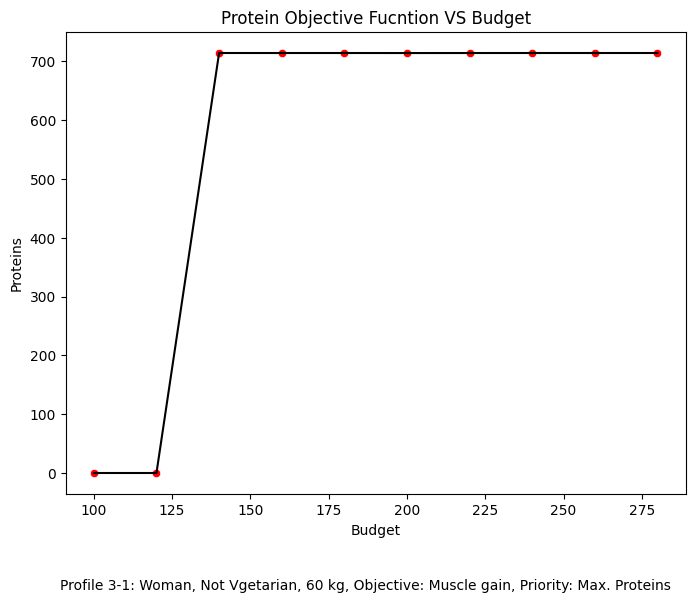

In [ ]:
#Chart of protein intake vs budget

plt.figure(figsize = (8,6))
sns.scatterplot(data = result, x = 'Budget', y = 'Proteins', color = 'red') 

# Lineplot connecting the dots
sns.lineplot(data=result, x='Budget', y='Proteins', color='black')
plt.title("Protein Objective Fucntion VS Budget")
plt.figtext(0.5, -0.05, "Profile 3-2: Woman, Vgetarian, 60 kg, Objective: Muscle gain, Priority: Sustainability", 
            ha="center", fontsize=10)



Text(0.5, -0.05, 'Profile 3-1: Woman, Vgetarian, 60 kg, Objective: Muscle gain, Priority: Sustainability')

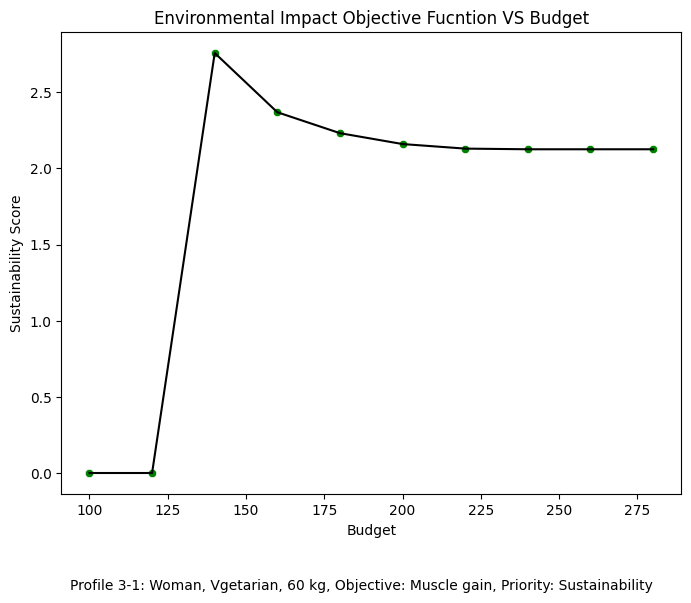

In [ ]:
#Chart of sustainablity score vs budget

plt.figure(figsize = (8,6))
sns.scatterplot(data = result, x = 'Budget', y = 'Sustainability Score', color = 'green') 

# Lineplot connecting the dots
sns.lineplot(data=result, x='Budget', y='Sustainability Score', color='black')
plt.title("Environmental Impact Objective Fucntion VS Budget")
plt.figtext(0.5, -0.05, "Profile 3-2: Woman, Vgetarian, 60 kg, Objective: Muscle gain, Priority: Sustainability", 
            ha="center", fontsize=10)

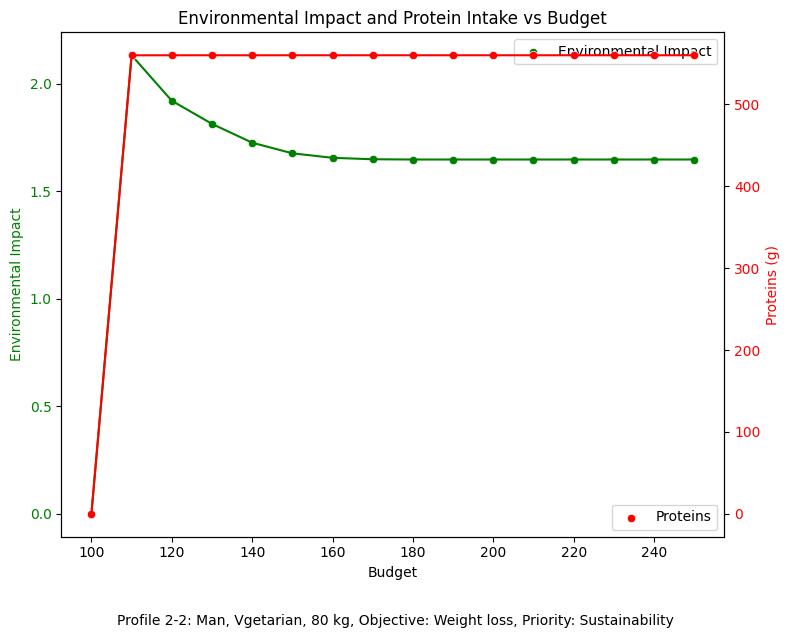

In [48]:
#Having both in one combo graph
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# First plot: Environmental Impact vs Budget
sns.scatterplot(data=result, x='Budget', y='Sustainability Score', color='green', ax=ax1, label='Environmental Impact')
sns.lineplot(data=result, x='Budget', y='Sustainability Score', color='green', ax=ax1)
ax1.set_ylabel('Environmental Impact', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title("Environmental Impact and Protein Intake vs Budget")
ax1.set_xlabel('Budget')

# Second plot: Proteins vs Budget on a twin axis
ax2 = ax1.twinx()
sns.scatterplot(data=result, x='Budget', y='Proteins', color='red', ax=ax2, label='Proteins')
sns.lineplot(data=result, x='Budget', y='Proteins', color='red', ax=ax2)
ax2.set_ylabel('Proteins (g)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a shared caption below the plot
fig.text(0.5, -0.05, "Profile 2-2: Man, Vgetarian, 80 kg, Objective: Weight loss, Priority: Sustainability", 
         ha="center", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
